# Clustering - Tuto 0

In this 1st tuto, we simply play with KMeans and GMM on a toy multimodal dataset

The objective is to illustrate a "clustering" method

** If you run this notebook at colab.research.google.com, you need to install packages with the fo

! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis intake intake-xarray scikit-learn matplotlib seaborn
! apt-get -qq install python-cartopy python3-cartopy


In [1]:
# Libraries import section
import os

import xarray as xr
import numpy as np

from tuto_tools import *

import matplotlib
%matplotlib inline

import pandas as pd

# Create a dummy dataset

we use a 2D sample datasets with Normal distributions

The dataset array is in "X", true labels in "y"


In [3]:
n = 500 # Number of samples per cluster

# Create the 2st cluster:
il = 0 # Init cluster IDs
s = new_sample([10,0],1,n=n)
X, y = s['data'], s['labels'] # 1st label is "0"

# Add another one:
il += 1
X, y = np.concatenate((X,new_sample([5,0],2,n=n)['data']),axis=0), np.concatenate((y,np.full((n),il)),axis=0)

# Add another one:
il += 1
X, y = np.concatenate((X,new_sample([5,5],0.7,n=n)['data']),axis=0), np.concatenate((y,np.full((n),il)),axis=0)

# Add another one:
il += 1
x = translate(rotate(stretch(new_sample([0,0],1,n=2*n)['data'],m=[5,1]),a=45),v=[0,5])
X, y = np.concatenate((X,x),axis=0), np.concatenate((y,np.full((2*n),il)),axis=0)

# Final nb of clusters:
n_clusters_true = il+1
print("Create a dummy dataset with %i clusters"%n_clusters_true)

Create a dummy dataset with 4 clusters


Text(0.5, 1.0, 'True 4 cluster labels')

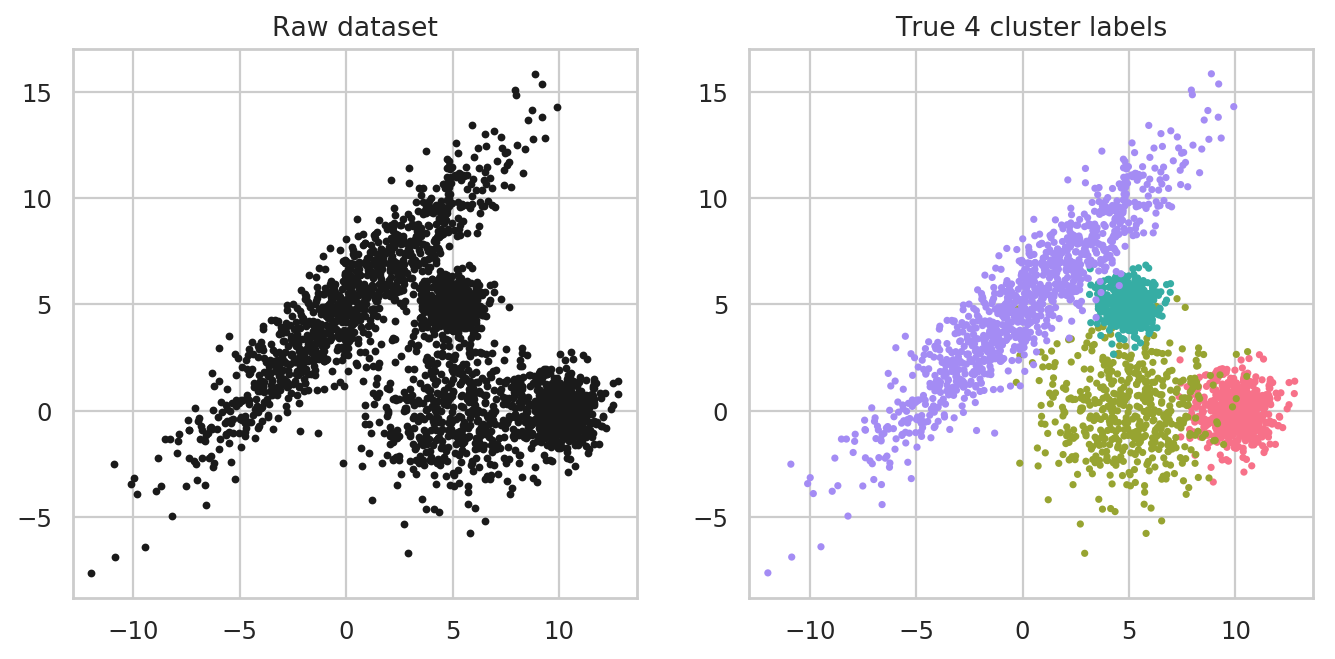

In [4]:
# Plot the dummy dataset
plt.figure(figsize=(10,10), dpi=160, facecolor='w', edgecolor='k')
plt.subplot(221)
plt.plot(X[:, 0], X[:, 1],'k.',markersize=5)
plt.axis('equal')
plt.title("Raw dataset")
plt.subplot(222)
plt.scatter(X[:, 0], X[:, 1], 5, c=y, cmap=ListedColormap(sns.husl_palette(n_clusters_true).as_hex()))
plt.axis('equal')
plt.title("True %i cluster labels"%n_clusters_true)

# Clustering with KMeans

To see how KMeans iterates to identify clusters, see the Stanford interactive tool:

http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html

In [6]:
from sklearn.cluster import KMeans

# Create the classifier:
kmeans = KMeans(n_clusters=n_clusters_true, random_state=0)

# Train the classifier:
kmeans.fit(X)

# Classify the dataset:
labels = kmeans.predict(X)

#
n_clusters_ = kmeans.n_clusters
print("Cluster centers shape:",kmeans.cluster_centers_.shape)
print("Cluster centers:\n",kmeans.cluster_centers_)

Cluster centers shape: (4, 2)
Cluster centers:
 [[ 9.77864348e+00 -3.82636373e-03]
 [-2.62757661e+00  2.31832527e+00]
 [ 4.03064181e+00  6.36914659e+00]
 [ 4.60875170e+00 -3.13388057e-01]]


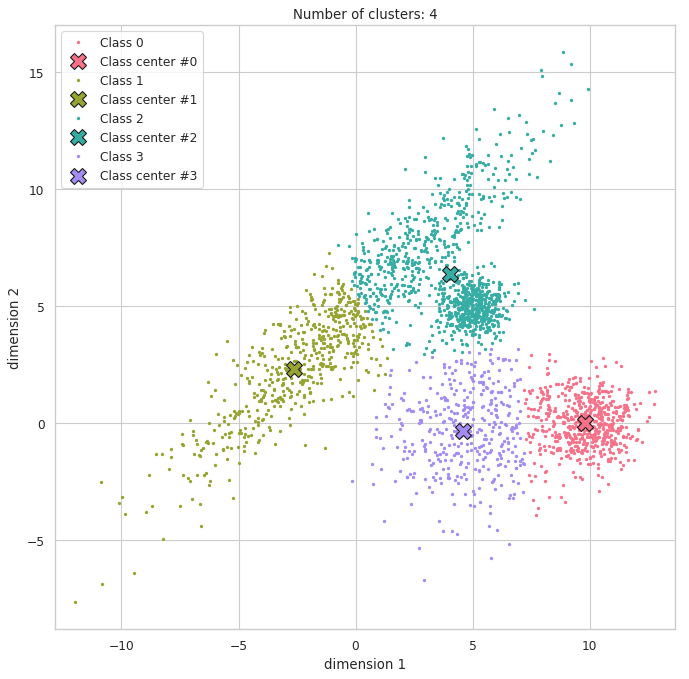

In [7]:
# Plot labels of data with cluster centers:
fig, ax, colors = plot2d_labels(X,labels,cluster_centers=kmeans.cluster_centers_,kmarkersize=14)

# Clustering with GMM

In [8]:
from sklearn.mixture import GaussianMixture as GMM

# Create classifier:
gmm = GMM(n_components=n_clusters_true, random_state=0)

# Train it:
gmm.fit(X)

# Classify data:
labels = gmm.predict(X)

# 
n_clusters_ = gmm.n_components
print("Cluster centers shape:",gmm.means_.shape)
print("Cluster centers:\n",gmm.means_)

Cluster centers shape: (4, 2)
Cluster centers:
 [[ 0.08316926  5.03446312]
 [ 5.0044715   4.98506933]
 [ 9.98137751  0.0214117 ]
 [ 5.00376014 -0.09949925]]


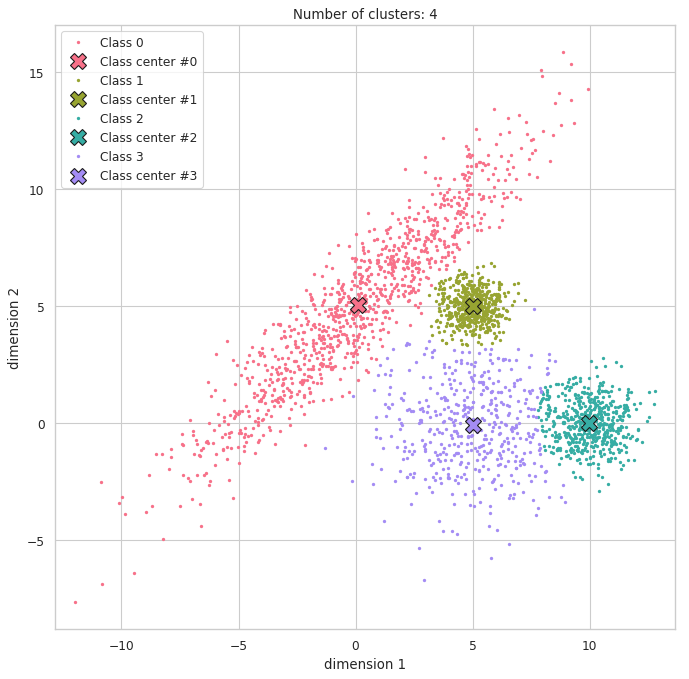

In [9]:
# Plot labels of data with cluster centers:
fig, ax, colors = plot2d_labels(X,labels,cluster_centers=gmm.means_,kmarkersize=14)

## Visualise Gaussian Modes of each clusters

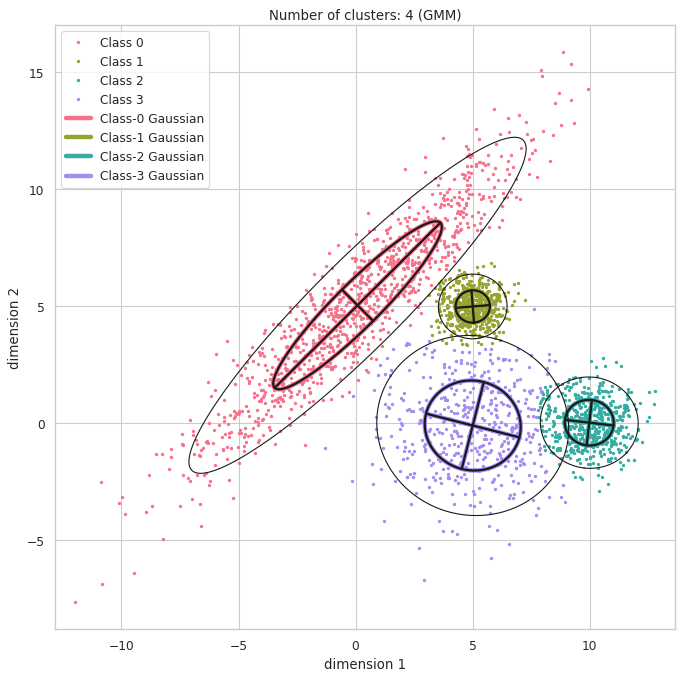

In [10]:
# Simple plot with labelled data:
fig, ax, colors = plot2d_labels(X, labels, dpi=80)

# Super-impose the GMM modes:
for k, col in zip(range(n_clusters_), colors):
    el,ax = plot_GMMellipse(gmm,k,col,ax,std=[1],label="Class-%i Gaussian"%(k),linewidth=4)
    el,ax = plot_GMMellipse(gmm,k,'k',ax,std=[1],linewidth=2)
    el,ax = plot_GMMellipse(gmm,k,'k',ax,std=[2],linewidth=1)
#     id = [0,1]
#     covariances = gmm.covariances_[k][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
#     print "Cluster %i covariance matrix:\n"%k, covariances
#     print "Cluster %i center matrix:\n"%k, gmm.means_[k,:]

ax.axis('equal')
plt.title('Number of clusters: %i (GMM)' % n_clusters_)
plt.legend()
plt.show()

## Super-imposed Gaussian Modes with the dataset pdf

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'kind'
  s)
/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwa

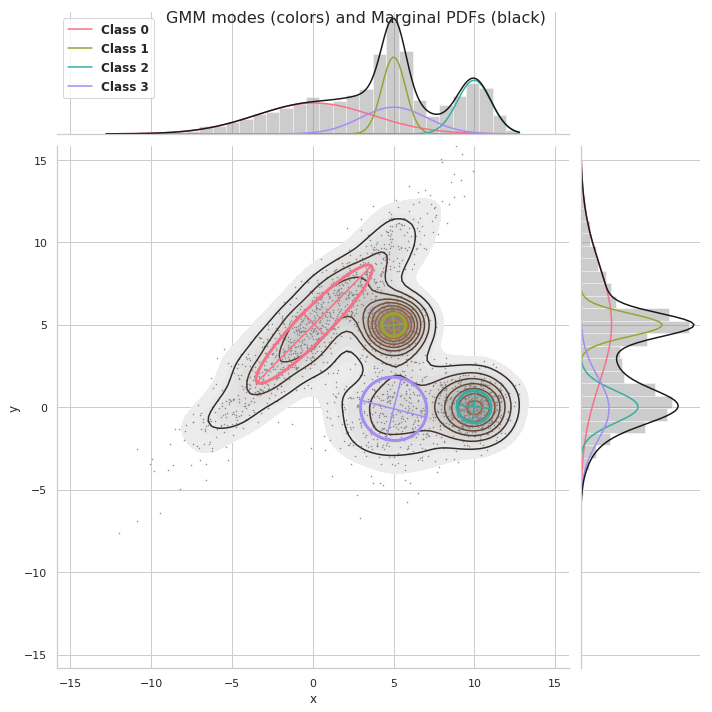

In [11]:
# Assemble variables to use in a Pandas dataframe:
df = pd.DataFrame(np.concatenate((X,labels[np.newaxis].T),axis=1), columns=["x", "y", "labels"])

# Plot the 2d data, with GMM modes and marginal distributions:
g = sns_plot2d_GMM_marginals(df, gmm)

## Exercice

Shape the shape of the covariance matrix in the GMM and visualise new results

The option name is `covariance_type` and possible values are `['spherical', 'diag', 'tied', 'full']`

In [ ]:
from sklearn.mixture import GaussianMixture as GMM